# 04 Combine files and descriptive statistics (Climate)
Combine the following files for further analyses and descriptive statistics:
- Manually annotated search queries (ICR + 90% sample)
- Other search query indicators
- Background characteristics

This notebook returns files used for LCA analysis and regression analysis in R, descriptive statistics, as well as a file for robustness check (looser selection criteria: at least two valid search queries).

In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import json
from tqdm import tqdm
from fuzzywuzzy import fuzz

/Users/marieke/Library/Python/3.8/lib/python/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/marieke/Library/Python/3.8/lib/python/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# setting paths
PATH = '/Users/marieke/SearchingForBias'

In [3]:
df = pd.read_pickle(PATH+'/data/climate/02_df_sq_vars.pkl')
df.shape

(1994, 19)

In [4]:
#BACKGROUND VARS
df_bg = pd.read_pickle(PATH+'/data/climate/01_df_bg.pkl')
df_bg.shape

(1994, 12)

In [5]:
df_bg = df_bg.set_index("ID", drop=True)

In [6]:
## merge 
df = pd.merge(df, df_bg, left_index=True, right_index=True, how="left")
df = df.reset_index()

In [7]:
#df.head()

In [8]:
## Annotated file (manually fixed encoding issues)
sq = pd.read_excel(PATH+"/data/climate/manual_coding/sq_cc_annotation_18062021_full_coded_TDV_encoding.xlsx", engine='openpyxl')
sq.shape

(2671, 25)

In [9]:
# matches (in different word order)
with open(PATH+'/data/climate/manual_coding/sq_matches_14062021.txt', 'r') as fi:
    matches = json.load(fi)

In [10]:
# add rows to sq for search queries with different word order
df_list=[]
for k, v in matches.items():
    for i in v:
        #print(i)
        tmpdf = sq.loc[sq['search query'] == k].copy()
        tmpdf['search query'] = i
        df_list.append(tmpdf)

In [11]:
# append matches rows to sq tot make sq_total
sq_total = sq.append(pd.concat(df_list), ignore_index=True, sort=True)
sq_total.shape

<ipython-input-11-38b7c9405222>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq_total = sq.append(pd.concat(df_list), ignore_index=True, sort=True)


(2758, 25)

In [12]:
# append columns for each search query match, for each search query column in the main df.
# search query col 1
tmpdf = sq_total.copy()
tmpdf.columns = [c+"_1" for c in tmpdf.columns]
df = pd.merge(df, tmpdf, left_on="MVH_search_cc_1_lp", right_on="search query_1", how="left")

In [13]:
# search query col 2
tmpdf = sq_total.copy()
tmpdf.columns = [c+"_2" for c in tmpdf.columns]
df = pd.merge(df, tmpdf, left_on="MVH_search_cc_2_lp", right_on="search query_2", how="left")

In [14]:
# search query col 3
tmpdf = sq_total.copy()
tmpdf.columns = [c+"_3" for c in tmpdf.columns]
df = pd.merge(df, tmpdf, left_on="MVH_search_cc_3_lp", right_on="search query_3", how="left")

In [15]:
# missing search query --> invalid search query
df.loc[df['search query_1'].isna(), 'GELDIG_1'] = 0
df.loc[df['search query_2'].isna(), 'GELDIG_2'] = 0
df.loc[df['search query_3'].isna(), 'GELDIG_3'] = 0

In [16]:
# how many valid search queries per person.
df['total_valid'] = df[['GELDIG_1', 'GELDIG_2', 'GELDIG_3']].sum(axis=1)
df['total_valid'].value_counts(dropna=False) #,normalize=True)*100

3.0    1729
2.0      97
0.0      92
1.0      76
Name: total_valid, dtype: int64

In [17]:
df['total_valid'].value_counts(dropna=False,normalize=True)*100

3.0    86.710130
2.0     4.864594
0.0     4.613842
1.0     3.811434
Name: total_valid, dtype: float64

In [18]:
### descriptive: age, education, gender (for sample selection bias)
round(df.opl_3cat.value_counts(normalize=True, dropna=False)*100)

2    52.0
3    40.0
1     8.0
Name: opl_3cat, dtype: float64

In [19]:
round(df.base_gender.value_counts(normalize=True, dropna=False)*100)

1    50.0
2    49.0
3     0.0
Name: base_gender, dtype: float64

In [20]:
round(df.base_lft.mean())

46

In [21]:
# only include respondents with three valid search queries.
df = df[((df.GELDIG_1==1)&(df.GELDIG_2==1)&(df.GELDIG_3==1))].copy()
df.shape # new sample size: 1729

(1729, 107)

In [22]:
# only Dutch and English present
for c in ['TAAL_1', 'TAAL_2', 'TAAL_3']:
    print(pd.DataFrame(df[c].value_counts(dropna=False)))

     TAAL_1
0.0    1672
1.0      57
     TAAL_2
0.0    1660
1.0      69
     TAAL_3
0.0    1674
1.0      55


In [23]:
# combine variables in one 'overall' variable for all three search queries.
sq_cols = [c for c in sq_total.columns if c not in ["Comments", "search query"]]
#sq_cols

In [24]:
sq_cols

['ACTIVISME',
 'CO2',
 'DISCUSSIE',
 'EFFECTIEF',
 'ENERGIE',
 'GELDIG',
 'GEVOLG',
 'INDIVIDUEEL_GEDRAG',
 'INDUSTRIE',
 'INFO_OPLOSSINGEN',
 'INFO_STATUS_QUO',
 'MILIEU',
 'ONGECATEGORISEERD',
 'OORZAKEN',
 'POLITIEK_BELEID',
 'SCEPTICI',
 'SCEPTICI_PERSONEN',
 'SPECIFIEK',
 'STIKSTOF',
 'TAAL',
 'VERVOER',
 'VOEDSELINDUSTRIE',
 'VRAAG']

In [25]:
for c in sq_cols:
    df[c] = np.where(df[[f'{c}_1', f'{c}_2', f'{c}_3']].sum(axis=1)>=1, 1, 0)

In [26]:
df.head()

,ID,MVH_search_cc_1,MVH_search_cc_2,MVH_search_cc_3,MVH_search_cc_1_lp,MVH_search_cc_2_lp,MVH_search_cc_3_lp,MVH_search_cc_1_lp_nwords,MVH_search_cc_2_lp_nwords,MVH_search_cc_3_lp_nwords,...,OORZAKEN,POLITIEK_BELEID,SCEPTICI,SCEPTICI_PERSONEN,SPECIFIEK,STIKSTOF,TAAL,VERVOER,VOEDSELINDUSTRIE,VRAAG
1,2,klimaat,klimaatverandering,wereldwijd klimaat,klimaat,klimaatverandering,wereldwijd klimaat,1,1,2,...,0,0,0,0,0,0,0,0,0,0
2,3,Climate change,What causes the global warming?,Klimaatverandering,climate change,what causes the global warming,klimaatverandering,2,5,1,...,1,0,0,0,1,0,1,0,0,1
3,4,Global warming,C02,Greenhouse gases,global warming,c02,greenhouse gases,2,1,2,...,0,0,0,0,1,0,1,0,0,0
4,5,klimaatbeleid Nederland,CO2 uitstoot,Klimaat,klimaatbeleid nederland,co2 uitstoot,klimaat,2,2,1,...,0,1,0,0,1,0,0,0,0,0
5,6,Uitstoot China,Co2,Uitstoot Verenigde Staten,uitstoot china,co2,uitstoot verenigde staten,2,1,3,...,0,0,0,0,1,0,0,0,0,0


In [27]:
### save df for LCA analysis
df.to_csv(PATH+"/data/climate/df_analysis.csv",sep='\t', index=False)

### DESCRIPTIVE STATISTICS

In [28]:
cols_lp = ["MVH_search_cc_1_lp", "MVH_search_cc_2_lp", "MVH_search_cc_3_lp"]

In [29]:
# how many unique search queries
all_sq = [item for sublist in df[cols_lp].values.tolist() for item in sublist]
print("total number of valid search queries:", len(all_sq))
tmplst = set(all_sq)
print("unique search queries:", len(tmplst))

total number of valid search queries: 5187
unique search queries: 2415


In [30]:
doubles = []
for i, element in enumerate(tqdm(tmplst)):
    for sq in list(tmplst)[i+1:]:
        if fuzz.token_sort_ratio(element, sq)>=100:
            doubles.append(element)
        else:
            pass

100%|██████████| 2415/2415 [08:31<00:00,  4.72it/s]


In [31]:
u_sq = [c for c in list(tmplst) if c not in doubles]
print("unique search queries regardless of word order:", len(u_sq))

unique search queries regardless of word order: 2331


In [32]:
# average length of search queries
df["im_len_mean"].describe()

count    1729.000000
mean       17.771930
std         8.828548
min         2.666667
25%        12.000000
50%        16.000000
75%        22.000000
max        77.333333
Name: im_len_mean, dtype: float64

In [33]:
# average number of words per search query.
df['im_nwords_mean'].describe()

count    1729.000000
mean        2.217852
std         1.437472
min         1.000000
25%         1.333333
50%         1.666667
75%         2.666667
max        14.000000
Name: im_nwords_mean, dtype: float64

In [34]:
# descriptives for indicators

In [35]:
varnames1 = ['SPECIFIEK', 'EFFECTIEF', 'VRAAG', 'TAAL']
varnames2= [c for c in sq_cols if c not in varnames1]

In [36]:
varnames2

['ACTIVISME',
 'CO2',
 'DISCUSSIE',
 'ENERGIE',
 'GELDIG',
 'GEVOLG',
 'INDIVIDUEEL_GEDRAG',
 'INDUSTRIE',
 'INFO_OPLOSSINGEN',
 'INFO_STATUS_QUO',
 'MILIEU',
 'ONGECATEGORISEERD',
 'OORZAKEN',
 'POLITIEK_BELEID',
 'SCEPTICI',
 'SCEPTICI_PERSONEN',
 'STIKSTOF',
 'VERVOER',
 'VOEDSELINDUSTRIE']

In [37]:
#tmp1 = pd.DataFrame([(df[varnames1].mean()*100), (df[varnames1].apply(pd.Series.value_counts).T[1])], columns=["Freq (%)", "N"])
tmp1 = pd.DataFrame(round(df[varnames1+varnames2].mean()*100, 1), columns=["Freq (%)"])
tmp2 = pd.DataFrame((df[varnames1+varnames2].apply(pd.Series.value_counts).T[1]))

In [38]:
sq_des = tmp1.join(tmp2)
sq_des = sq_des.sort_values(sq_des.columns[1], ascending=False)
sq_des.to_latex(PATH+"/report/tables/climate/sq_descriptives.tex")
sq_des

<ipython-input-38-0c1d3c95b117>:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  sq_des.to_latex(PATH+"/report/tables/climate/sq_descriptives.tex")


,Freq (%),1
GELDIG,100.0,1729.0
SPECIFIEK,98.7,1707.0
EFFECTIEF,97.3,1683.0
GEVOLG,41.4,716.0
POLITIEK_BELEID,35.5,614.0
INFO_STATUS_QUO,26.5,459.0
MILIEU,18.4,319.0
INFO_OPLOSSINGEN,15.1,261.0
VRAAG,13.8,239.0
CO2,13.1,226.0


In [39]:
# clean up dataframe
#drop valid,specific,language,question,effectief
names = {'GEVOLG':'Consequences',
         'POLITIEK_BELEID':'Politics & policy',
         'INFO_STATUS_QUO':'Trends and current status',
         'MILIEU':'Environmental problems',
         'INFO_OPLOSSINGEN':'Solutions',
         'CO2':'Carbon',
         'INDIVIDUEEL_GEDRAG':'Individual behaviour',
         'ENERGIE':'Energy',
         'SCEPTICI':'Climate change denial',
         'ACTIVISME':'Activism',
         'DISCUSSIE':'Debate',
         'STIKSTOF':'Nitrogen',
         'VOEDSELINDUSTRIE':'Agriculture',
         'OORZAKEN':'Causes',
         'VERVOER':'Transport',
         'INDUSTRIE':'Industry',
         'SCEPTICI_PERSONEN':'Climate change deniers'
        }
sq_des = sq_des[sq_des.index.isin(list(names.keys()))]
sq_des.index=sq_des.index.map(names)

In [40]:
list(names.keys())

['GEVOLG',
 'POLITIEK_BELEID',
 'INFO_STATUS_QUO',
 'MILIEU',
 'INFO_OPLOSSINGEN',
 'CO2',
 'INDIVIDUEEL_GEDRAG',
 'ENERGIE',
 'SCEPTICI',
 'ACTIVISME',
 'DISCUSSIE',
 'STIKSTOF',
 'VOEDSELINDUSTRIE',
 'OORZAKEN',
 'VERVOER',
 'INDUSTRIE',
 'SCEPTICI_PERSONEN']

In [41]:
sq_des

,Freq (%),1
Consequences,41.4,716.0
Politics & policy,35.5,614.0
Trends and current status,26.5,459.0
Environmental problems,18.4,319.0
Solutions,15.1,261.0
Carbon,13.1,226.0
Individual behaviour,12.1,209.0
Energy,11.2,194.0
Climate change denial,4.2,72.0
Activism,4.1,71.0


In [42]:
# bar graph
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper")
sns.set(font='serif')
sns.set_style("whitegrid")
plt.figure(figsize=(45,75))

<Figure size 3240x5400 with 0 Axes>

<Figure size 3240x5400 with 0 Axes>

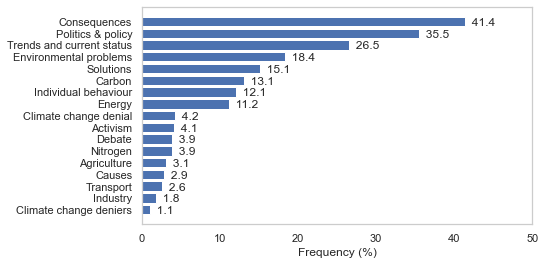

In [43]:
plt.figure(figsize=(7,4))
plt.xlabel('Frequency (%)')
plt.gca().invert_yaxis()
plt.xlim([0, 50])
plt.grid(False)
for index, value in enumerate(sq_des['Freq (%)']):
    plt.text(value, index, "  "+str(value), va='center_baseline')
plt.barh(sq_des.index, sq_des['Freq (%)'])
plt.savefig(PATH+"/report/figures/climate/sq_descriptives.eps", format='eps', dpi=600, bbox_inches='tight', pad_inches = 0)
plt.show()

In [45]:
# how many specific search queries per person.
df['total_specific'] = df[['SPECIFIEK_1', 'SPECIFIEK_2', 'SPECIFIEK_3']].sum(axis=1)
df['total_specific'].value_counts(dropna=False,normalize=True)*100

3.0    49.566223
2.0    39.733950
1.0     9.427415
0.0     1.272412
Name: total_specific, dtype: float64

### Independent variables

In [46]:
df['edu_low'] = np.where(df.opl_3cat==1,1,0)
df['edu_mid'] = np.where(df.opl_3cat==2,1,0)
df['edu_high'] = np.where(df.opl_3cat==3,1,0)
df['base_gender2'] = np.where(df.base_gender==1,1,0)

In [47]:
iv_cat = ['edu_low', 'edu_mid', 'edu_high', 'base_gender2']
iv_con = ['att_cc_mean', 'MVH_att_importance_2', 'base_polar', 'base_intpol', 
          'base_lft']

In [48]:
# mean age, gender and education for search query sample
des2 = round(df[iv_con+iv_cat].describe().T[['mean', 'std','min', 'max']],2)
des2

,mean,std,min,max
att_cc_mean,4.83,1.50,1.0,7.0
MVH_att_importance_2,3.86,0.98,1.0,5.0
base_polar,5.09,2.30,0.0,10.0
base_intpol,5.17,2.55,0.0,10.0
base_lft,46.11,14.93,18.0,77.0
edu_low,0.07,0.26,0.0,1.0
edu_mid,0.51,0.50,0.0,1.0
edu_high,0.41,0.49,0.0,1.0
base_gender2,0.49,0.50,0.0,1.0


In [49]:
df_miss = df[((df.base_polar.isna())|(df.base_intpol.isna())|(df.base_gender==3))]
df_miss

,ID,MVH_search_cc_1,MVH_search_cc_2,MVH_search_cc_3,MVH_search_cc_1_lp,MVH_search_cc_2_lp,MVH_search_cc_3_lp,MVH_search_cc_1_lp_nwords,MVH_search_cc_2_lp_nwords,MVH_search_cc_3_lp_nwords,...,STIKSTOF,TAAL,VERVOER,VOEDSELINDUSTRIE,VRAAG,total_specific,edu_low,edu_mid,edu_high,base_gender2
1,2,klimaat,klimaatverandering,wereldwijd klimaat,klimaat,klimaatverandering,wereldwijd klimaat,1,1,2,...,0,0,0,0,0,0.0,0,1,0,0
14,15,Klimaat,Verandering,Gevaar,klimaat,verandering,gevaar,1,1,1,...,0,0,0,0,0,1.0,0,1,0,0
19,20,Klimaat wat kan ik er aan doen,Is het klimaat nog te redden,Wat zijn de gevolgen als we zo doorgaan met he...,klimaat wat kan ik er aan doen,is het klimaat nog te redden,wat zijn de gevolgen als we zo doorgaan met he...,7,6,11,...,0,0,0,0,1,3.0,1,0,0,1
28,29,Klimaat,politiek,klimaat en politiek,klimaat,politiek,klimaat en politiek,1,1,3,...,0,0,0,0,0,2.0,0,1,0,0
62,63,klimaat,aarde,natuur,klimaat,aarde,natuur,1,1,1,...,0,0,0,0,0,2.0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,1950,klimaatverandering toekomst,klimaatverbetering,status klimaatverandering,klimaatverandering toekomst,klimaatverbetering,status klimaatverandering,2,1,2,...,0,0,0,0,0,3.0,0,0,1,0
1956,1957,Opwarming aarde,Klimaat,Discussie punt,opwarming aarde,klimaat,discussie punt,2,1,2,...,0,0,0,0,0,2.0,0,1,0,1
1969,1970,Co2,Stikstof,opwarming aarde,co2,stikstof,opwarming aarde,1,1,2,...,1,0,0,0,0,3.0,0,1,0,1
1992,1993,geld,energie,windmolen,geld,energie,windmolen,1,1,1,...,0,0,0,0,0,3.0,0,1,0,0


In [50]:
df_miss.shape

(134, 135)

In [51]:
# exclude respondents with missing values on key IV
df_reg = df[~((df.base_polar.isna())|(df.base_intpol.isna())|(df.base_gender==3))]
df_reg.shape

(1595, 135)

In [52]:
# cronbach's alpha for climate scale
pg.cronbach_alpha(df[["MVH_att_cc_1", "MVH_att_cc_2"]])

(0.7110020241568622, array([0.682, 0.737]))

In [54]:
#des = round(df_reg[iv_con+iv_cat+vote].describe().T[['mean', 'std','min', 'max']],2)
des = round(df_reg[iv_con+iv_cat].describe().T[['mean', 'std','min', 'max']],2)
des.to_latex(PATH+"/report/tables/climate/iv_descriptives.tex")
des

<ipython-input-54-472cfc52d176>:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  des.to_latex(PATH+"/report/tables/climate/iv_descriptives.tex")


,mean,std,min,max
att_cc_mean,4.85,1.51,1.0,7.0
MVH_att_importance_2,3.88,0.97,1.0,5.0
base_polar,5.09,2.29,0.0,10.0
base_intpol,5.36,2.43,0.0,10.0
base_lft,46.40,14.87,18.0,77.0
edu_low,0.07,0.25,0.0,1.0
edu_mid,0.50,0.50,0.0,1.0
edu_high,0.43,0.50,0.0,1.0
base_gender2,0.51,0.50,0.0,1.0


In [55]:
keep = [c for c in df_reg.columns if not any(z in c for z in (varnames1+varnames2+["MVH_search", 'Comments']))]
df_reg = df_reg[keep].copy()

In [56]:
df_reg.shape

(1595, 28)

In [57]:
### save df for regression analysis
df_reg.to_csv(PATH+"/data/climate//df_reg.csv", index=False)